# Logistická regrese

Úloha zaměřená na implementaci logistické regrese metodou GD.

V případě klasifikace požaduje výstup systému ve smyslu rozhodnutí o příslušnosti k jedné ze dvou definovaných tříd. Přiřadíme datům z jedné třídy požadovanou výstupní hodnotu +1 a datům z druhé třídy 0 (příp. -1)

**Nechceme aproximovat body, ale separovat třídy!**


## Binární lineární klasifikátor pomocí logistické regrese
Umí klasifikovat jen třídy separovatelné lineárně (přimkou).

### Data

Data reprezentují výsledky zkoušky A a B a rozhodnutí o přijetí studenta na VŠ (křížek – neúspěch; hvezdička – úspěch). 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import vsu

In [4]:
def show_loss(iterations, loss):
    plt.plot(iterations, loss)
    plt.xlabel("Iterace")
    plt.ylabel("Loss")
    plt.title("Průběh trénování")
    plt.show()

In [5]:
npzfile = np.load('data/data_06_lr.npz')
npzfile.files


['data', 'ref']

In [6]:
data = npzfile['data']
ref = npzfile['ref']
data.shape, ref.shape


((100, 2), (100, 1))

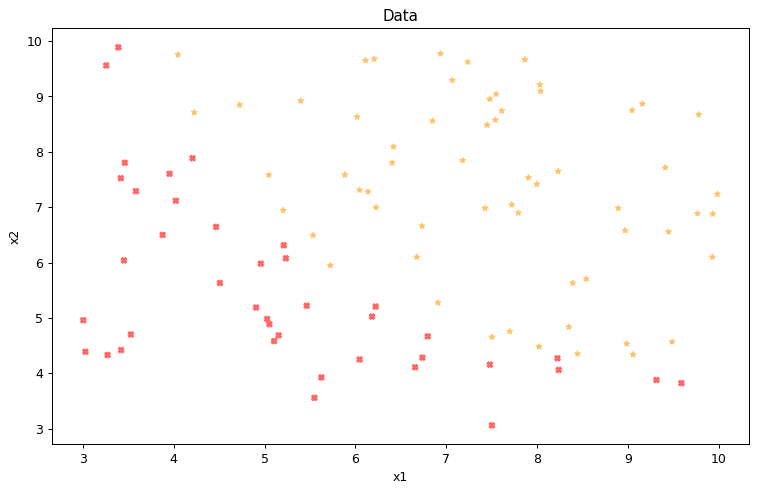

In [7]:
vsu.drawSoftmax(data, ref)


### Opakování z matematiky 

- Obecný tvar rovnice přimky v prostoru o souřadnicích $x_0$ ... $x_n$ má tvar:
    $$ w_0 x_0 + w_1 x_1 + ... + w_n x_n + b = \sum_{i=0}^{n} w_i x_i + b = w^T x + b = x^T w + b = 0 $$

kde $w$ je normalový vektor (kolmý na směr přímky), 

$b$ je bias,  souvisí s posunem přímky od počátku,

$w^T x$ je skalární součin vektorů $w$ a $x$

- Bias $b$ taky můžeme označit jako $w_{n+1}$, pak platí:
$$ w_0 x_0 + w_1 x_1 + ... + w_n x_n + w_{n+1} = \sum_{i=0}^{n} w_i \tilde{x_i} = w^T \tilde{x} = \tilde{x}^T w = 0 $$

kde $\tilde{x}$ je $x$ rozšířená o jeden sloupec s hodnotami 1, např. pro 2D:

$$
    x = 
        \begin{bmatrix}
        x_0 & x_1 \\
        \end{bmatrix} 
    \implies
        \tilde{x} = 
        \begin{bmatrix}
        x_0 & x_1 & 1 \\
        \end{bmatrix} 
$$

- Poloha bodu vůči přímce ve 2D:
Orientovaná vzdálenost $d$ bodu $x$ od přímky s parametry $w$:
$$ d = \frac{w_0 x_0 + w_1 x_1 + b}{ \sqrt{w_0^2 + w_1^2}} $$

Bod $x$ leží ve vzdálenosti $d$:
- ve směru vektoru $w$ (nad přímkou): $d > 0$, tedy $w^T x + b > 0$
- proti směru vektoru $w$ (pod přímkou): $d < 0$, tedy $w^T x + b < 0$
- přímo na přímce: $d = 0$, tedy $w^T x + b = 0$



### Sigmoida
$$ sigmoid(u) = \sigma (u) = \frac{e^u}{1+e^u} = \frac{1}{1+e^{-u}} $$

kde $u = w^T \tilde{x}$


Vlastnosti:
- definiční obor: ($-\infty$, $+\infty$)
- obor hodnot: (0,1)
- $ \sigma (u) > 0.5 $ pro $u>0$, $ \sigma (u) < 0.5 $ pro $u<0$


- Pokud je hodnota na výstupu sigmoidy $\geq$ 0.5, přiřadíme bod ke třídě 1.
- Pokud je hodnota na výstupu sigmoidy < 0.5, přiřadíme bod ke třídě 0.


### Výpočet $\theta$

#### Pomocí sumy:

$$ \theta_{t+1} = \theta_{t} - \alpha \sum_{i=0}^{N} {x_i} (\sigma(x_i^T \theta_t) - y_i) $$
kde $\alpha$ je velikost kroku (learning rate), $y_i \in {0,1}$


#### Pomocí  matice:
Maticová implementace je řádově výpočetně efektivnější bez použití cyklu for.

$$ \theta_{t+1} = \theta_{t} - \alpha X^T (\sigma(X \theta_t) - y) $$
matice $X$ obsahuje v káždém sloupci jeden rozšířený vektor $x_i$


#### Výpočet $\theta$ s funkcionalitou pro regularizaci:
$$ \theta_{t+1} = \theta_{t}(1 - \alpha \lambda) - \alpha \sum_{i=0}^{N} {x_i} (\sigma(x_i^T \theta_t) - y_i) $$

nebo
$$ \theta_{t+1} = \theta_{t} (1 - \alpha \lambda) - \alpha X^T (\sigma(X \theta_t) - y) $$



#### Postup:
1. Parametr $\theta$ (resp. váhy $w$ a bias $b$) se inicializuje na malé náhodné hodnoty nebo na nuly
2. Na vstup se přivedou všechna trénovací data a na výstupu se tím pádem objeví posloupnost nul a jedniček (obsahuje chyby)
3. Na základě chyb se upraví hodnoty vah
4. Kroky 2. a 3. se postupně opakují, dokud dostatečně klesá chybovost klasifikátoru (nebo podle počtu iterací)


In [8]:
def sigmoid(z):
    """
    vstupem muze byt skalar, vektor, nebo matice 
    """
    
    #################################################################
    # ZDE DOPLNIT

    return 1.0 / (1.0 + np.exp(-z))

    #################################################################

vsu.checkSigmoid(sigmoid) #kontrola vystupu, output musi byt True

/tmp/ipykernel_8707/410691413.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return 1.0 / (1.0 + np.exp(-z))


True

In [ ]:
def thetaGD(data, classes, alpha=0.001, iterations=10000, lmbd=0, plot_loss=False):
    """
    alpha = learning rate
    plot_loss - zobraz graf zavislosti lossu na iteraci
    """

    # pro kazdou iteraci vypoctete loss a zapiste ho na odpovidajici index v promenne
    # (jak ovlivní regularizace výpočet lossu?)
    loss = np.zeros(iterations)

    #################################################################
    # ZDE DOPLNIT
    
    X_input = np.asarray(data, dtype=float)
    y = np.asarray(classes, dtype=float).reshape(-1, 1)

    N, d = X_input.shape

    X = np.hstack([np.ones((N, 1)), X_input])

    theta = np.zeros((d + 1, 1))

    for i in range(iterations):
        z = X @ theta
        sigm = sigmoid(z)

        loss[i] = -(y * np.log(sigm) + (1 - y) * np.log(1 - sigm)).mean()

        theta = theta * (1 - alpha * lmbd) - alpha * (X.T @ (sigm - y))

        
    #################################################################

    if plot_loss:
        show_loss(np.arange(iterations), loss)

    return theta


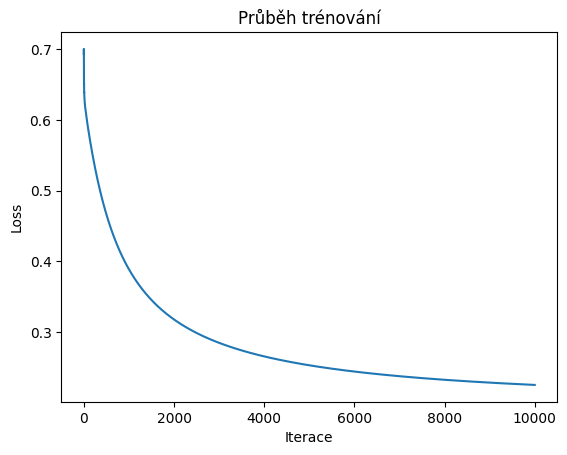

array([[-15.32914513],
       [  1.27729209],
       [  1.21940235]])

In [25]:
theta = thetaGD(data,ref,alpha=0.001,iterations=10000, plot_loss=True)

theta

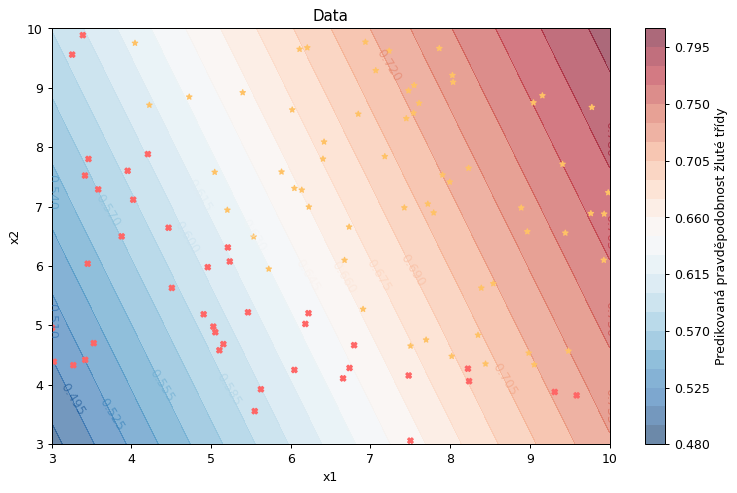

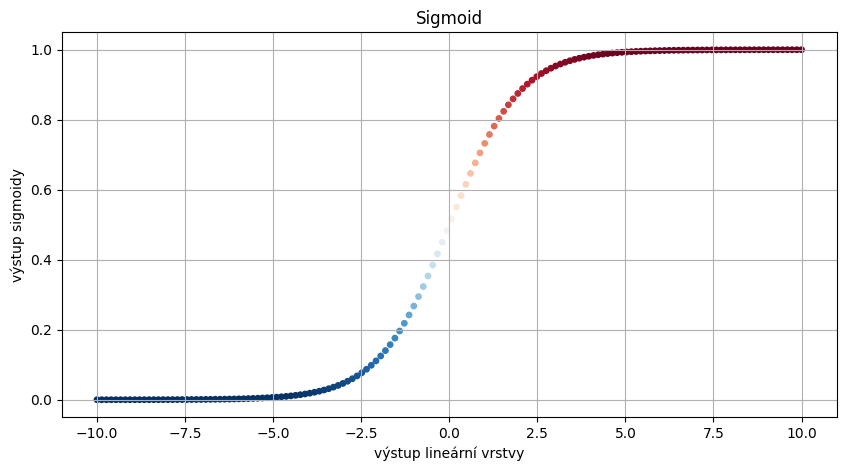

In [11]:
vsu.drawSigmoid(data, ref, theta, sigmoid)
vsu.drawSigmoidShape(sigmoid, title="Sigmoid")


In [ ]:
def predict(x, theta):
    #určí pro libovolnou kombinaci vstupu theta a X výsledné přiřazení ke třídě 
    #(p < 0.5, třída 0; p >= 0.5, třída 1),
    
    #################################################################
    # ZDE DOPLNIT
    
    X = np.asarray(x, dtype=float)
    if X.ndim == 1:
        X = X.reshape(1, -1)

    N, d = X.shape
    X_tilde = np.hstack([np.ones((N, 1)), X])
    p = sigmoid(X_tilde @ theta)
    print(p)
    #################################################################

    return (p >= 0.5).astype(int)


Rozhodněte o přijetí v případě zisku 6 a 4 bodů a nastavení parametrů: alpha = 0.001,lambda = 0.2, počet iterací = 10000:

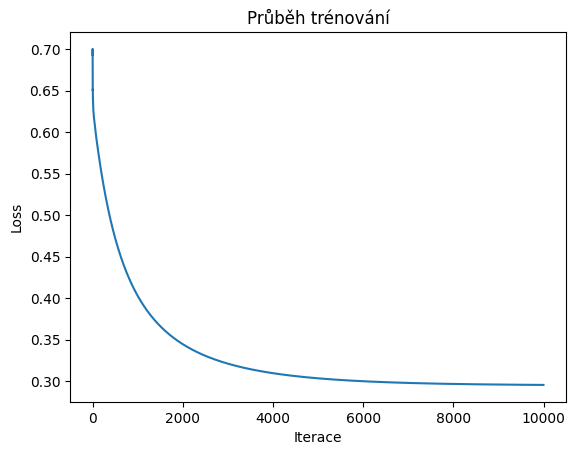

[[0.19792889]]


np.int64(0)

In [35]:
#################################################################
# ZDE DOPLNIT

theta_reg = thetaGD(data, ref, alpha=0.001, iterations=10000, lmbd=0.2, plot_loss=True)

decision = predict([6.0, 4.0], theta_reg)[0, 0]

decision

#################################################################
